# Métodos de Ensemble


## Instabilidade

Vamos montar um modelo clássico para identificação de mensagens de spam. O modelo consiste em contar quantas vezes uma determinada palavra aparece na mensagem e classificá-la como spam ou não. **O foco da aula não é o modelo, mas estudar a estabilidade dele!**

### Coleta e limpeza de dados

In [1]:
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# dataset de mensagens de email
df = pd.read_csv('../datasets/spam_ham.csv')

df.head()


,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [3]:
# um pouco de preprocessamento

def clean_text(df_input, column_to_clean):
    
    # converte para letras minusculas
    df_input['text_clean'] = df_input[column_to_clean].str.lower()
    
    # remove pontução
    remover = f"[{string.punctuation}]"
    df_input['text_clean'] = df_input['text_clean'].str.replace(remover, ' ', regex=True)
    
    # remove numeros
    numeros = f"[1234567890]"
    df_input['text_clean'] = df_input['text_clean'].str.replace(numeros, '', regex=True)
    
    return df_input['text_clean']

# criar coluna text clean
df['text_clean'] = clean_text(df, 'text')

df.head()

,type,text,text_clean
0,ham,Hope you are having a good week. Just checking in,hope you are having a good week just checking in
1,ham,K..give back my thanks.,k give back my thanks
2,ham,Am also doing in cbe only. But have to pay.,am also doing in cbe only but have to pay
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",complimentary star ibiza holiday or £ cash n...
4,spam,okmail: Dear Dave this is your final notice to...,okmail dear dave this is your final notice to...


### Divisão do dataset

In [4]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split

def create_train_test_sets(df_input, semente):
    X = df_input['text_clean'].copy()
    y = df_input['type'].map({'ham':0, 'spam': 1})


    X_treino_bruto, X_teste_bruto, y_treino_, y_teste_ = train_test_split(X, y, 
                                                                          test_size=0.3, 
                                                                          random_state=semente)
    # preparação para a aula de NLP - exercicío do WordCount
    bag_of_words = CountVectorizer(max_features=100)
    bag_of_words.fit(X_treino_bruto)
    
    X_treino_ = bag_of_words.transform(X_treino_bruto)
    X_teste_ = bag_of_words.transform(X_teste_bruto)
    
    return X_treino_, X_teste_, y_treino_, y_teste_

# cria os datasets de treino e teste na prática
X_treino, X_teste, y_treino, y_teste = create_train_test_sets(df, 13)

In [5]:
print(y_treino.shape,y_teste.shape,)

(3891,) (1668,)


In [6]:
X_treino.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 2, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 2]])

In [7]:
df.loc[1830,'text_clean']

'sir  i have been late in paying rent for the past few months and had to pay a      charge  i felt it would be inconsiderate of me to nag about something you give at great cost to yourself and that s why i didnt speak up  i however am in a recession and wont be able to pay the charge this month hence my askin well ahead of month s end  can you please help  thanks'

### Função para avaliar o modelo

In [8]:
def evaluate_model(df_input, modelo, scoring_function, semente):
    
    X_treino_, X_teste_, y_treino_, y_teste_ = create_train_test_sets(df_input, semente)
    
    modelo.fit(X_treino_, y_treino_)
    
    y_pred = modelo.predict_proba(X_teste_)
    
    score = scoring_function(y_teste_, y_pred[:,1])
    
    return score
    

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [10]:
tree_model=DecisionTreeClassifier(random_state=2)

X_treino, X_teste, y_treino, y_teste = create_train_test_sets(df, semente=13)

tree_model.fit(X_treino, y_treino)

y_pred=tree_model.predict_proba(X_teste)

score=roc_auc_score(y_teste,y_pred[:,1])
score

0.8966712898751733

In [11]:
tree_model=DecisionTreeClassifier(random_state=2)
evaluate_model(df,tree_model,roc_auc_score,13)

0.8966712898751733

### O que acontece quando mudamos os dados de treino?

In [12]:
# decision tree classifier
evaluate_model(df,tree_model,roc_auc_score,42)

0.8860721407033215

In [13]:
evaluate_model(df,tree_model,roc_auc_score,85)

0.8928489439853076

In [14]:
evaluate_model(df,tree_model,roc_auc_score,100)

0.891400896920794

In [15]:
sementes=[semente for semente in range(15)]
sementes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [16]:
scores=[evaluate_model(df, tree_model, roc_auc_score, semente=i) for i in sementes]
scores

[0.9074436810243223,
 0.8927344809109568,
 0.8813116216683711,
 0.8954288323165107,
 0.8736636635718588,
 0.9032948924027762,
 0.909859062170706,
 0.9104271727155647,
 0.880179398148148,
 0.8856000027014979,
 0.8892384692384693,
 0.9009227069393045,
 0.909213193236464,
 0.8966712898751733,
 0.9058040982727176]

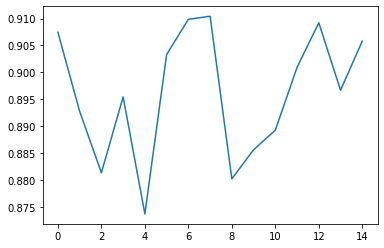

In [17]:
sns.lineplot(x=sementes,y=scores)

**Para pensar:** só mudamos quais emails estamos usando para treinar e a performance está instável!

### Enfim, as instabilidade!

In [18]:
# função que sumariza QUASE TODOS os passos acima

def plot_scores(quantidade, modelo_eval, score_eval):
    sementes = [i for i in range(quantidade)]
    scores = [evaluate_model(df, modelo=modelo_eval, scoring_function=score_eval, semente=j) for j in sementes]
    
    sns.lineplot(x=sementes, y=scores)
    print(f"média: {np.mean(scores)}, desvio padrão: {np.std(scores)}")

média: 0.8961195043461896, desvio padrão: 0.011574075616600933


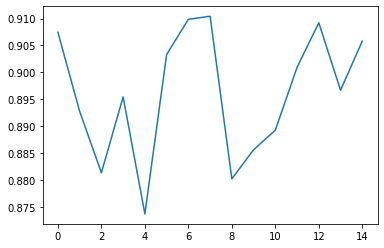

In [19]:
plot_scores(15,tree_model,roc_auc_score)

# Bagging
Um meio de evitar a instabilidade é treinar diversos modelos **em paralelo** com **amostras** dos dados (técnia de **bootstrapping**) e combinar a decisão de todos eles no final. No caso de *regressão* fazemos a **média** dos resultados e para *classificação*, uma **votação**.

* Bootstrapping: Amostragem dos dados com reposição
* Modelos em paralelo: um modelo é idependente do outro
* Weak learner: Conjunto de amostra de dados + instancia do modelo


<img src="images/bagging_sketch.png">

In [27]:
# implementação do BaggingClassifier no sklearn
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

modelo=LogisticRegression()

bc= BaggingClassifier(base_estimator=modelo, n_estimators=10,max_samples=1.0, random_state=9)

bc.fit(X_treino,y_treino)

y_pred=bc.predict(X_teste)

roc_auc_score(y_teste,y_pred)

0.8875639782504634

média: 0.9684035442241576, desvio padrão: 0.006351766915157323


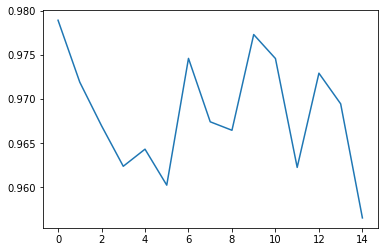

In [33]:
# será que é mais estável?
modelo=LogisticRegression()
bc= BaggingClassifier(base_estimator=modelo, n_estimators=10,max_samples=1.0,max_features=1.0, random_state=9)
plot_scores(quantidade=15,modelo_eval=bc,score_eval=roc_auc_score)


média: 0.9540891390867523, desvio padrão: 0.010027531767909029


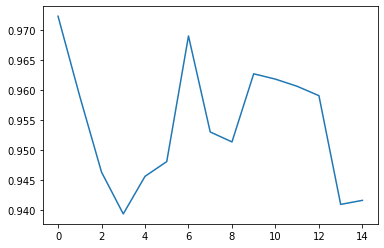

In [30]:
# será que é mais estável?
modelo=DecisionTreeClassifier()
bc= BaggingClassifier(base_estimator=modelo, n_estimators=10,max_samples=1.0,max_features=1.0, random_state=9)
plot_scores(quantidade=15,modelo_eval=bc,score_eval=roc_auc_score)


média: 0.9704933212285861, desvio padrão: 0.008133116757579469


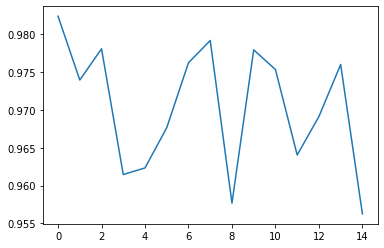

In [35]:
# será que é mais estável?
modelo=DecisionTreeClassifier()
bc= BaggingClassifier(base_estimator=modelo, n_estimators=20,max_samples=0.7,max_features=0.6, random_state=9)
plot_scores(quantidade=15,modelo_eval=bc,score_eval=roc_auc_score)


**Para pensar:** Qual o custo da estabilidade trazida pelo bagging?
> Estabilidade aumenta com o aumento de weak learners, porém também aumenta o tempo de processamento  

In [45]:
%%timeit

modelo=DecisionTreeClassifier()

bc= BaggingClassifier(base_estimator=modelo, n_estimators=100,max_samples=1.0, random_state=9)

bc.fit(X_treino,y_treino)

y_pred=bc.predict(X_teste)

roc_auc_score(y_teste,y_pred)

2.75 s ± 241 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Bagging of trees: **Random Forest**

Aplica a técnica de bootstrapping para criar diversas árvores!

- cada árvore é um weak learned! 

<img src="images/random_forest.png">

In [37]:
# implementação do random forest no sklearn
from sklearn.ensemble import RandomForestClassifier

>A implementação do Random Forest é muito mais eficiente do que implementar um bagging de árvores na mão

In [44]:
%%timeit
rfc=RandomForestClassifier(n_estimators=100, random_state=9)
rfc.fit(X_treino,y_treino)
y_pred=rfc.predict(X_teste)

roc_auc_score(y_teste,y_pred)

735 ms ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


média: 0.9742440486355727, desvio padrão: 0.0062596190210580235


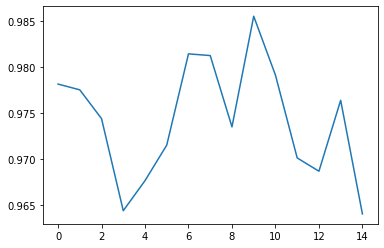

In [43]:
plot_scores(quantidade=15,modelo_eval=rfc,score_eval=roc_auc_score)

# Boosting

Ao contrário do bagging, o método de boosting treina diversos modelos **em sequência**. 

<img src="images/boosting.png">




Essa técnica usa todos os dados e a cada iteração atribui diferentes pesos (importâncias) para os pontos que são classificados erroneamente (pode se tornar obcecado por outilers!). 

<img src="images/boosting1.jpeg">

<img src="https://i.stack.imgur.com/mQ9Np.png"/>

## Entendo os pesos!

Text(0, 0.5, 'a_m')

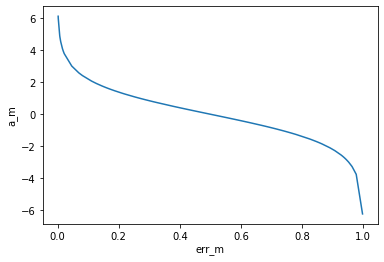

In [46]:
err_m = np.sort(np.random.random(100))

def a_m(x):
    return np.log((1-x)/x)

plt.plot(err_m, a_m(err_m))
plt.xlabel('err_m')
plt.ylabel('a_m')

## Algoritimos de boosting

### [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost): Adaptative boosting

In [50]:
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor

In [51]:
modelo=LogisticRegression()

abc=AdaBoostClassifier(base_estimator=modelo, n_estimators=50, random_state=9)

abc.fit(X_treino,y_treino)

y_pred=abc.predict(X_teste)

roc_auc_score(y_teste,y_pred)

0.8159420912449523

média: 0.9675669201145948, desvio padrão: 0.005713056799854984


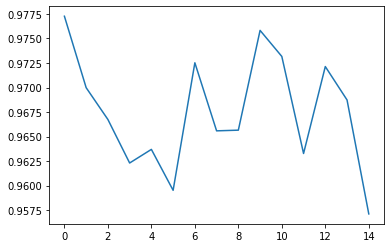

In [53]:
modelo=LogisticRegression()
abc=AdaBoostClassifier(base_estimator=modelo, n_estimators=50, random_state=9)

plot_scores(quantidade=15,modelo_eval=modelo, score_eval=roc_auc_score)

média: 0.8978600191896847, desvio padrão: 0.015559177010852385


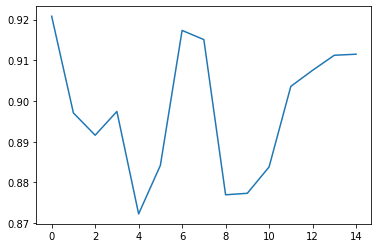

In [54]:
modelo=DecisionTreeClassifier()
abc=AdaBoostClassifier(base_estimator=modelo, n_estimators=50, random_state=9)

plot_scores(quantidade=15,modelo_eval=modelo, score_eval=roc_auc_score)

### [LightGBM](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html): Light Gradient Boosting Machine
>Ele vai tentando diminuir o erro, é um algoritmo de árvore

pip install lightgbm

> **USADO NO ITAÚ**

In [48]:
#!pip install lightgbm

In [56]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()

lgbm.fit(X_treino*1.0, y_treino*1.0) #Multiplicamos por 1.0 pq precisa ser float 

y_pred = lgbm.predict(X_teste*1.0)

roc_auc_score(y_teste, y_pred)

0.917712002749377

In [64]:
# plot_scores(quantidade=15*1.0,modelo_eval=lgbm, score_eval=roc_auc_score)

### [Xgboost](https://xgboost.readthedocs.io/en/latest/): Extreme gradient boosting
> É um algoritmo de árvore

pip install xgboost

In [58]:
# !pip install xgboost

In [60]:
from xgboost import XGBClassifier

xgc = XGBClassifier(verbosity=1)

xgc.fit(X_treino, y_treino)

y_pred = xgc.predict(X_teste)

roc_auc_score(y_teste, y_pred)

/home/zgiuliana/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:34:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9170185214733715

In [ ]:
plot_scores(quantidade=15,modelo_eval=modelo, score_eval=roc_auc_score)

# Bonus: Stacking models

Para expandir nosso horizonte, vamos estender as idéais acima para a combinação de diferentes modelos, técnica conhecida como [Stacking](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html).

In [63]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


nosso_estimator = [
    ('lr', LogisticRegression()),
    ('tree', DecisionTreeClassifier())
]

sc = StackingClassifier(estimators=nosso_estimator, final_estimator=KNeighborsClassifier(), cv=7)

sc.fit(X_treino, y_treino)

y_pred = sc.predict(X_teste)
roc_auc_score(y_teste, y_pred)

0.9044376664661913